

Metrics that I might implement:

https://www.kdnuggets.com/2018/04/right-metric-evaluating-machine-learning-models-1.html

to do list:



*   Implement the new metrics from the papers, put them into the tables, and comparate them.

* Find a way to test more hyperparameters faster and search about "BayeSearch".




# **All dependencies that are necessary**

In [ ]:
!pip install arff
!pip install tensorflow
!pip install --upgrade scipy

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline
from sklearn import preprocessing
from os import listdir
from os.path import isfile, join
from datetime import datetime,date
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping
from tensorflow.keras import initializers
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error
from scipy.stats import ttest_ind
import math
import json

# **Opening the data set**

The data set is loaded from a CSV file named "meteorological_data" that I created and cleaned in my other python file. Check out "generateData" to obtain more information about.

In [2]:
dataFrame=pd.read_csv('meteorological_data.csv')

dataFrame['mes'] = [mes[5:7] for mes in dataFrame['data completa'] ]
dataFrame['ano'] = [ano[0:4] for ano in dataFrame['data completa'] ]
id_2 = ['A305','A306','A314','A315','A319','A324','A325','A332','A339','A342','A347','A358','A359','A360','A368','A369']
localization = ['FORTALEZA','SOBRAL','GUARAMIRANGA','BARBALHA','IGUATU','TAUA','QUIXERAMOBIM','MORADA NOVA','JAGUARUANA','CRATEUS','CAMPOS SALES','JAGUARIBE','ITAPIPOCA','ACARAU','TIANGUA','QUIXADA']


display(dataFrame)

,TEMPERATURA MAXIMA NA HORA ANT. (AUT)(°C),UMIDADE REL. MAX. NA HORA ANT. (AUT)(%),TEMPERATURA MINIMA NA HORA ANT. (AUT)(°C),UMIDADE REL. MIN. NA HORA ANT. (AUT)(%),RADIACAO GLOBAL(Kj/m²),"PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)","UMIDADE RELATIVA DO AR, HORARIA(%)","VENTO, VELOCIDADE HORARIA(m/s)",latitude,longitude,altura,estacao_id,dia do ano,data completa,temperatura media,Eo_samani,Eo_FAO,mes,ano
0,29.6,84.0,26.7,68.0,2478.500000,1008.690909,77.636364,2.381818,-0.066599,-0.672610,29.55,0.0,49,2003-02-18,28.15,2.815185,2.158130,02,2003
1,31.5,95.0,24.3,62.0,1320.500000,1008.700000,80.750000,2.329167,-0.066599,-0.672610,29.55,0.0,50,2003-02-19,27.90,4.412632,4.312026,02,2003
2,27.6,95.0,24.1,78.0,2386.444444,1008.354167,88.333333,1.279167,-0.066599,-0.672610,29.55,0.0,51,2003-02-20,25.85,2.939072,3.032922,02,2003
3,30.8,96.0,22.0,61.0,1246.666667,1008.354167,83.083333,1.708333,-0.066599,-0.672610,29.55,0.0,52,2003-02-21,26.40,4.719712,4.768149,02,2003
4,31.2,94.0,24.2,59.0,1431.000000,1008.283333,82.041667,1.858333,-0.066599,-0.672610,29.55,0.0,53,2003-02-22,27.70,4.333662,4.317706,02,2003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65718,36.8,42.0,31.7,31.0,3055.208250,988.400000,33.500000,3.075000,-0.086896,-0.681677,193.00,15.0,339,2019-12-05,34.25,4.155351,3.864984,12,2019
65719,37.6,33.0,34.7,28.0,2419.698000,985.700000,29.000000,2.200000,-0.086896,-0.681677,193.00,15.0,341,2019-12-07,36.15,3.246348,2.578275,12,2019
65720,34.9,67.0,29.4,40.0,1530.386800,988.720000,51.200000,2.600000,-0.086896,-0.681677,193.00,15.0,342,2019-12-08,32.15,4.138430,3.941287,12,2019
65721,35.1,76.0,26.6,36.0,2624.976200,989.040000,45.400000,3.860000,-0.086896,-0.681677,193.00,15.0,343,2019-12-09,30.85,5.009957,4.618717,12,2019


In [3]:
param_grid = {
    'learning_rate':[0.001, 0.01],
#    'momentum' : [0.0, 0.2, 0.4, 0.6],
    'features_delete':[
      #                 ['RADIACAO GLOBAL(Kj/m²)'],
                       ['PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)','RADIACAO GLOBAL(Kj/m²)','VENTO, VELOCIDADE HORARIA(m/s)'],
                       ['UMIDADE RELATIVA DO AR, HORARIA(%)','UMIDADE REL. MIN. NA HORA ANT. (AUT)(%)','UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)','PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)','RADIACAO GLOBAL(Kj/m²)','VENTO, VELOCIDADE HORARIA(m/s)'],
                       ],
    'epochs':[10,20,30,40,50],
    'data_date':['2010-02-11','2013-02-11','2015-02-11']
    }
parameters=list(ParameterGrid(param_grid))
display(len(parameters))

60

# **Class and methods used**

This section contains all methods and classes necessary to perform the evapotranspiration predictions by neural network and evaluation of their results. Most functions and methods names are self-explanatory.

In [117]:
#from tensorflow.python.keras.utils.version_utils import ModelVersionSelector
class Neural_test:

  def __init__(self,dataframe,drop_columns):

    self.data=dataFrame.drop(labels=drop_columns,axis=1)
  
  def splitting_data(self,date,name_empirical_model):

    empirical_model=[]
    self.data['data completa'] = pd.to_datetime(self.data['data completa'])
    self.data = self.data.set_index(self.data['data completa'])
    self.data = self.data.sort_index()
    
    self.train_dataset = self.data[date[0]:date[1]]
    self.test_dataset  = self.data[date[2]:]
   
    self.test_date=self.test_dataset.index

    self.train_labels = self.train_dataset.loc[:,'Eo_FAO']
    self.test_labels = self.test_dataset.loc[:,'Eo_FAO']

    self.empirical_model=self.test_dataset.loc[:,name_empirical_model]

    self.train_dataset=self.train_dataset.drop(labels=name_empirical_model,axis=1)
    self.test_dataset=self.test_dataset.drop(labels=name_empirical_model,axis=1)

    self.mes = self.test_dataset['mes']
    self.estacao_id = self.test_dataset['estacao_id']
    self.ano = self.test_dataset['ano']

    self.train_dataset=self.train_dataset.drop(labels=['data completa','Eo_FAO','estacao_id','mes','ano'],axis=1)
    self.test_dataset=self.test_dataset.drop(labels=['data completa','Eo_FAO','estacao_id','mes','ano'],axis=1)


  def standardize_data(self):

    scaler = StandardScaler()

    scaler.fit(self.train_dataset)
    self.normed_train_data=pd.DataFrame(scaler.transform(self.train_dataset))
    scaler.fit(self.test_dataset)
    self.normed_test_data=pd.DataFrame(scaler.transform(self.test_dataset))

  def get_train(self):
    return self.train_dataset

  def Model(self,Loss,Metrics,activation_function,Learning_rate):

    #This method creates the neural network model with 2 intermediate layers, 5 neurons in each layer and 
    #the other parameters are going to received through function argument defined by the user.

    initializer = tf.keras.initializers.HeNormal(seed=1)

    model = keras.Sequential([
    layers.Dense(5, activation=activation_function, input_shape=[len(self.normed_train_data.keys())],kernel_initializer=initializer),
    layers.Dense(5, activation=activation_function,kernel_initializer=initializer),
    layers.Dense(1)
    ])


    optimizer = tf.keras.optimizers.RMSprop(learning_rate=Learning_rate)
    
    model.compile(loss=Loss,
                optimizer=optimizer,
                metrics=Metrics
                )
    
    self.model=model
    
  def Fit(self,Epochs,Validation_split,Verbose,show_history=True):

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=50)
    
    history = self.model.fit(
    x=self.normed_train_data,
    y=self.train_labels,
    validation_split=Validation_split,
    verbose=Verbose,
    epochs=Epochs
    #callbacks=[es]
    )

    if show_history:
      historico = pd.DataFrame(history.history)
      historico['epoch'] = history.epoch
      display(historico.tail())

    return history
    
  def prediction(self):

    self.prediction_test = self.model.predict(self.normed_test_data).flatten()
    self.prediction_test=pd.Series(self.prediction_test)
  
  def compare(self,limit,show=False):
    
    [test_labels,empirical_model]=[self.test_labels,self.empirical_model]

    if show:
      plt.plot(test_labels[0:limit].reset_index(drop=True),test_labels[0:limit].reset_index(drop=True))      
      plt.plot(test_labels[0:limit].reset_index(drop=True),self.prediction_test[0:limit],'x')
      plt.plot(test_labels[0:limit].reset_index(drop=True),empirical_model[0:limit],'x')
      plt.ylabel('Rede Neural')
      plt.xlabel('Fao 56')
      plt.savefig('grap.png')
      plt.show()

    r2=r2_score(test_labels, self.prediction_test)
    #r2_2=r2_score(test_labels, empirical_model)
    print(r2)
    return r2



def get_results(parameters):
  
  [index,simulation_result,keys] = [0,dict(),['parameters','result','id','history']]

  for key in keys:
    simulation_result[key] = [] 

  for parameter in parameters:

    print('Parameters used:\n Features para serem deletadas: '+str(parameter['features_delete'])+' taxa de aprendizagem: '+str(parameter['learning_rate'])+' Epochs: '+str(parameter['epochs'])+' data: '+parameter['data_date']+'\n')
    neural_network = Neural_test(dataFrame,parameter['features_delete'])
    neural_network.splitting_data([parameter['data_date'],'2018-01-01','2018-01-02'],['Eo_samani'])
    neural_network.standardize_data()
    
    neural_network.Model('mse',['mae', 'mse'],'relu',parameter['learning_rate'])
    
    history = neural_network.Fit(parameter['epochs'],0.2,0,True)
    
    neural_network.prediction()
    
    coeficent=neural_network.compare(250)
    
    simulation_result['parameters'].append(parameter) 
    simulation_result['id'].append(index)
    simulation_result['result'].append(coeficent)
    simulation_result['history'] = history
    print(index)
    index+=1

  return simulation_result

def Creating_result_table(results_dict,load_dataset_from_excel):

  matrix = []

  if load_dataset_from_excel:
    for id in range(len(results_dict),0,-1):
      matrix.append([results_dict[id]['parameters']['data_date'],results_dict[id]['parameters']['epochs'],len(results_dict[id]['parameters']['features_delete']),results_dict[id]['parameters']['learning_rate'],results_dict[id]['result']])
  else:
    for id in range(len(results_dict)-1,0,-1):
      matrix.append([results_dict[id][1]['parameters']['data_date'],results_dict[id][1]['parameters']['epochs'],len(results_dict[id][1]['parameters']['features_delete']),results_dict[id][1]['parameters']['learning_rate'],results_dict[id][1]['result']])
  
  matrix = pd.DataFrame(matrix).rename(columns={0:'Data de inicio',1:'épocas',2:'features deletadas',3:'taxa de aprendizagem',4:'coeficiente de determinação'})
  
  return matrix

def make_prediction(dataFrame,parameter):

  neural_network = Neural_test(dataFrame,parameter['features_delete'])  
  neural_network.splitting_data([parameter['data_date'],'2018-01-01','2018-01-02'],['Eo_samani'])
  neural_network.standardize_data()
  neural_network.Model('mse',['mae', 'mse'],'relu',parameter['learning_rate'])
  history = neural_network.Fit(parameter['epochs'],0.2,0,False)

  neural_network.prediction()
  neural_network.compare(350)
  return  [neural_network,history]


class organize():

  def __init__(self,simulation_result):

    self.simulation_result=simulation_result

  def organize_results_two_sets(self,qtd,store_excel=False):

    result_dic=dict()
    result_dic['results_of_simulation00'] = dict()
    result_dic['results_of_simulation01'] = dict()

    condition = [['PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'],['UMIDADE RELATIVA DO AR, HORARIA(%)', 'UMIDADE REL. MIN. NA HORA ANT. (AUT)(%)', 'UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)', 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)']]

    for index in range(len(simulation_result['id'])):

      #result_dic['simulation '+str(index)]={'parameters':simulation_result['parameters'][index],'id':simulation_result['id'][index],'history':simulation_result['history'][index],'result':simulation_result['result'][index]}
      for index2 in range(len(condition)):
        if simulation_result['parameters'][index]['features_delete'] == condition[index2]: 
          result_dic['results_of_simulation0'+str(index2)][simulation_result['id'][index]] = dict()
          result_dic['results_of_simulation0'+str(index2)][simulation_result['id'][index]]['result']=simulation_result['result'][index]
          result_dic['results_of_simulation0'+str(index2)][simulation_result['id'][index]]['parameters']=simulation_result['parameters'][index]

    results_of_simulation00 = sorted(result_dic['results_of_simulation00'].items(), key=lambda item: item[1]['result'])
    results_of_simulation01 = sorted(result_dic['results_of_simulation01'].items(), key=lambda item: item[1]['result'])
    
    if store_excel:

      pd.DataFrame(results_of_simulation00).to_excel("results_of_simulation00.xlsx",index=False)
      pd.DataFrame(results_of_simulation01).to_excel("results_of_simulation01.xlsx",index=False)
    
    return [results_of_simulation00,results_of_simulation01]

def get_results_stored_in_excel_and_convert_to_dict(name_excel):
    
  excel = pd.read_excel(name_excel)
  #display(excels[1][1][0])
  dataset = dict()

  for index in range(len(excel[1])-1,0,-1):
        
    dataset[index] = dict()
    json_data = json.loads(excel[1][index].replace("'",'"'))
    dataset[index]['parameters'] = json_data['parameters']
    dataset[index]['result'] = json_data['result']

  return dataset


def trim_axs(axs, N):
    """
    Reduce *axs* to *N* Axes. All further Axes are removed from the figure.
    """
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]


def get_graphs_and_metrics_grouped_by_estacao_id(prediction,test,split,year,localization,id_2,save_picture = False,show_picture = False):

  prediction_labels_gruopby_estacao_id = [x for x in prediction[prediction['ano']==year].groupby('estacao_id')]
  test_labels_gruopby_estacao_id = [x for x in test[test['ano']==year].groupby('estacao_id')]  
  
  station_name_index = [int(estation[1]['estacao_id'][0]) for estation in test_labels_gruopby_estacao_id]
  
  results_simulations_by_estation = dict()

  for index in range(len(station_name_index)):
    
    results_simulations_by_estation[localization[station_name_index[index] ] ] = dict()
    
    results_simulations_by_estation[localization[station_name_index[index] ] ]['código da estação'] = id_2[index]
    results_simulations_by_estation[localization[station_name_index[index] ] ]['Quantidade de dados'] = len(prediction_labels_gruopby_estacao_id[index][1]) 
    
    prediction_labels_gruopby_estacao_id_groupby_month=prediction_labels_gruopby_estacao_id[index][1].groupby([split]).mean().drop(columns={'estacao_id'})
    test_labels_gruopby_estacao_id_groupby_month=test_labels_gruopby_estacao_id[index][1].groupby([split]).mean().drop(columns={'estacao_id'})
    
    results_simulations_by_estation[localization[station_name_index[index] ] ]['coeficiente de determinação(dia)'] = r2_score(test_labels_gruopby_estacao_id[index][1]['Eo_FAO'],prediction_labels_gruopby_estacao_id[index][1][0])
    results_simulations_by_estation[localization[station_name_index[index] ] ]['MSE(dia)'] = mean_squared_error(test_labels_gruopby_estacao_id[index][1]['Eo_FAO'],prediction_labels_gruopby_estacao_id[index][1][0])

    axs = plt.figure(figsize=(13,3),constrained_layout=True).subplots(1, 3)
    axs = trim_axs(axs, 3)
    axs[0].plot(prediction_labels_gruopby_estacao_id[index][1][0].reset_index(drop=True),':', label = 'Rede Neural')
    axs[0].plot(test_labels_gruopby_estacao_id[index][1]['Eo_FAO'].reset_index(drop=True),':', label = 'FAO-56')
    axs[0].legend()
    axs[0].grid()
    axs[0].set_xlabel('dia')
    axs[0].set_ylabel('Eo')
    axs[0].set_title('Eo para a estação de '+str(localization[station_name_index[index]])+'(dia)')

    if save_picture:
      plt.savefig("evapotranspiration graph per day of estation "+str(localization[station_name_index[index]]))
    #print(prediction_labels_gruopby_estacao_id[index][1][0].drop(columns={'estacao_id','mes'}))
    #if show_picture:
    #  plt.show()

    coeficient_of_determination = r2_score(prediction_labels_gruopby_estacao_id_groupby_month,test_labels_gruopby_estacao_id_groupby_month)

    results_simulations_by_estation[localization[station_name_index[index] ] ]['coeficiente de determinação(mes)'] = coeficient_of_determination
    results_simulations_by_estation[localization[station_name_index[index] ] ]['MSE(mes)'] = mean_squared_error(prediction_labels_gruopby_estacao_id_groupby_month,test_labels_gruopby_estacao_id_groupby_month)

    axs[1].plot(prediction_labels_gruopby_estacao_id_groupby_month, label = 'Rede Neural')
    axs[1].plot(test_labels_gruopby_estacao_id_groupby_month, label = 'FAO-56')
    axs[1].legend()
    axs[1].grid()
    axs[1].set_xlabel(split)
    axs[1].set_ylabel('Eo')
    axs[1].set_title('Eo para a estação de '+str(localization[station_name_index[index]])+'(mes)')

    if save_picture:
      plt.savefig("evapotranspiration graph per month of estation "+str(localization[station_name_index[index]]))
    #print(prediction_labels_gruopby_estacao_id[index][1][0].drop(columns={'estacao_id','mes'}))
    #if show_picture:
    #  plt.show()

    axs[2].plot(test_labels_gruopby_estacao_id[index][1]['Eo_FAO'].drop(columns={'estacao_id','mes'}),test_labels_gruopby_estacao_id[index][1]['Eo_FAO'].drop(columns={'estacao_id','mes'}),label = 'FAO-56')
    axs[2].plot(test_labels_gruopby_estacao_id[index][1]['Eo_FAO'].drop(columns={'estacao_id','mes'}),prediction_labels_gruopby_estacao_id[index][1][0].drop(columns={'estacao_id','mes'}),'xb',label = 'Rede Neural')
    axs[2].legend()
    axs[2].grid()
    #plt.text(5,5,'r^2 = '+str(round(coeficient_of_determination,2)),ax.transAxes )
    axs[2].set_ylabel('Rede neural')
    axs[2].set_xlabel('FAO-56')
    if show_picture:
      plt.show()
    if save_picture:
      plt.savefig("evapotranspiration graph fdfedfsfsd "+str(id_2[index]))
    
  return pd.DataFrame(results_simulations_by_estation)



# **Prediction and Tuning**

In this section, the training results of the neural network models are going to shown and their hyperparameters will be selected based on the highest coefficients of determination. The algorithm makes and stores 90 predictions using all combinations of the above hyperparameters.                           

**Read-me**: The procedure of doing all training and predictions and obtaining the metrics from each hyperparameter takes too much time. To avoid this problem, I already saved the best results in two CSV files named "results_of_simulation00.xlsx" and "results_of_simulation01.xlsx". Set the  "load_dataset_from_excel" variable as True and you are going to be able to access the results as much as the parameters used without redoing the model training. 

In [ ]:
simulation_result = get_results(parameters)

In [5]:
load_dataset_from_excel = True

if load_dataset_from_excel:

  best_results_of_simulation00 = get_results_stored_in_excel_and_convert_to_dict('results_of_simulation00.xlsx')
  best_results_of_simulation01 = get_results_stored_in_excel_and_convert_to_dict('results_of_simulation01.xlsx')

else:

  organizing = organize(simulation_result)
  [best_results_of_simulation00,best_results_of_simulation01] = organizing.organize_results_two_sets(True,10)

result_table00 = Creating_result_table(best_results_of_simulation00,load_dataset_from_excel)
result_table01 = Creating_result_table(best_results_of_simulation01,load_dataset_from_excel)

In [6]:
parameter00 = {
    'learning_rate':result_table00[0:1]['taxa de aprendizagem'][0],
#    'momentum' : [0.0, 0.2, 0.4, 0.6],
    'features_delete':
                       ['PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)','RADIACAO GLOBAL(Kj/m²)','VENTO, VELOCIDADE HORARIA(m/s)'],
    'epochs':result_table00[0:1]['épocas'][0],
    'data_date':result_table00[0:1]['Data de inicio'][0]
    }

display(result_table00[0:10])
result_table00.groupby(['Data de inicio','épocas','taxa de aprendizagem']).mean()

,Data de inicio,épocas,features deletadas,taxa de aprendizagem,coeficiente de determinação
0,2010-02-11,60,3,0.010,0.948613
1,2010-02-11,40,3,0.010,0.946935
2,2010-02-11,30,3,0.010,0.943121
3,2010-02-11,40,3,0.001,0.942012
4,2015-02-11,30,3,0.010,0.940312
5,2013-02-11,30,3,0.010,0.939965
6,2010-02-11,10,3,0.001,0.938677
7,2013-02-11,40,3,0.001,0.936451
8,2010-02-11,60,3,0.001,0.935996
9,2013-02-11,30,3,0.001,0.934416


features deletadas  \
Data de inicio épocas taxa de aprendizagem                       
2010-02-11     10     0.001                                3.0   
                      0.010                                3.0   
               20     0.001                                3.0   
                      0.010                                3.0   
               30     0.001                                3.0   
                      0.010                                3.0   
               40     0.001                                3.0   
                      0.010                                3.0   
               60     0.001                                3.0   
                      0.010                                3.0   
2013-02-11     10     0.001                                3.0   
                      0.010                                3.0   
               20     0.001                                3.0   
                      0.010                                3.0   
               30     0.001                                3.0   
                      0.010                                3.0   
               40     0.001                                3.0   
                      0.010                                3.0   
               60     0.001                                3.0   
                      0.010                                3.0   
2015-02-11     10     0.001                                3.0   
                      0.010                                3.0   
               20     0.001                                3.0   
               30     0.001                                3.0   
                      0.010                                3.0   
               40     0.001                                3.0   
                      0.010                                3.0   
               60     0.001                                3.0   
                      0.010                                3.0   

                                            coeficiente de determinação  
Data de inicio épocas taxa de aprendizagem                               
2010-02-11     10     0.001                                    0.938677  
                      0.010                                    0.915325  
               20     0.001                                    0.927679  
                      0.010                                    0.932588  
               30     0.001                                    0.912462  
                      0.010                                    0.943121  
               40     0.001                                    0.942012  
                      0.010                                    0.946935  
               60     0.001                                    0.935996  
                      0.010                                    0.948613  
2013-02-11     10     0.001                                    0.914341  
                      0.010                                    0.929361  
               20     0.001                                    0.913565  
                      0.010                                    0.928181  
               30     0.001                                    0.934416  
                      0.010                                    0.939965  
               40     0.001                                    0.936451  
                      0.010                                    0.907580  
               60     0.001                                    0.924826  
                      0.010                                    0.910612  
2015-02-11     10     0.001                                    0.884124  
                      0.010                                    0.915784  
               20     0.001                                    0.909410  
               30     0.001                                    0.903649  
                      0.010                                    0.940312  

In [7]:
parameter01 = {
    'learning_rate':result_table01[0:1]['taxa de aprendizagem'][0],
#    'momentum' : [0.0, 0.2, 0.4, 0.6],
    'features_delete':
                       ['UMIDADE RELATIVA DO AR, HORARIA(%)','UMIDADE REL. MIN. NA HORA ANT. (AUT)(%)','UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)','PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)','RADIACAO GLOBAL(Kj/m²)','VENTO, VELOCIDADE HORARIA(m/s)'],
    'epochs':result_table01[0:1]['épocas'][0],
    'data_date':result_table01[0:1]['Data de inicio'][0]
    }
display(result_table01[0:10])
result_table01.groupby(['Data de inicio','épocas','taxa de aprendizagem']).mean()

,Data de inicio,épocas,features deletadas,taxa de aprendizagem,coeficiente de determinação
0,2010-02-11,30,6,0.010,0.950745
1,2010-02-11,10,6,0.010,0.946764
2,2010-02-11,60,6,0.010,0.942321
3,2010-02-11,60,6,0.001,0.939259
4,2013-02-11,40,6,0.010,0.938020
5,2010-02-11,20,6,0.010,0.934687
6,2015-02-11,30,6,0.010,0.933535
7,2013-02-11,30,6,0.010,0.931981
8,2013-02-11,60,6,0.001,0.930806
9,2013-02-11,60,6,0.010,0.930164


features deletadas  \
Data de inicio épocas taxa de aprendizagem                       
2010-02-11     10     0.001                                6.0   
                      0.010                                6.0   
               20     0.001                                6.0   
                      0.010                                6.0   
               30     0.001                                6.0   
                      0.010                                6.0   
               40     0.001                                6.0   
                      0.010                                6.0   
               60     0.001                                6.0   
                      0.010                                6.0   
2013-02-11     10     0.001                                6.0   
                      0.010                                6.0   
               20     0.001                                6.0   
               30     0.001                                6.0   
                      0.010                                6.0   
               40     0.001                                6.0   
                      0.010                                6.0   
               60     0.001                                6.0   
                      0.010                                6.0   
2015-02-11     10     0.001                                6.0   
                      0.010                                6.0   
               20     0.001                                6.0   
                      0.010                                6.0   
               30     0.001                                6.0   
                      0.010                                6.0   
               40     0.001                                6.0   
                      0.010                                6.0   
               60     0.001                                6.0   
                      0.010                                6.0   

                                            coeficiente de determinação  
Data de inicio épocas taxa de aprendizagem                               
2010-02-11     10     0.001                                    0.929858  
                      0.010                                    0.946764  
               20     0.001                                    0.923170  
                      0.010                                    0.934687  
               30     0.001                                    0.923521  
                      0.010                                    0.950745  
               40     0.001                                    0.925653  
                      0.010                                    0.912908  
               60     0.001                                    0.939259  
                      0.010                                    0.942321  
2013-02-11     10     0.001                                    0.872206  
                      0.010                                    0.922849  
               20     0.001                                    0.889438  
               30     0.001                                    0.915393  
                      0.010                                    0.931981  
               40     0.001                                    0.923729  
                      0.010                                    0.938020  
               60     0.001                                    0.930806  
                      0.010                                    0.930164  
2015-02-11     10     0.001                                    0.815294  
                      0.010                                    0.914127  
               20     0.001                                    0.905979  
                      0.010                                    0.929306  
               30     0.001                                    0.899748  
                      0.010                                    0.933535  

# **Evaluating the results**

## **All results of the simulation 00**

This subsection is included the graphs and metrics such as  $r^2$ and MSE per monthly mean and day. The graphs that present the monthly mean results are related to 2018, the year which contains most data from the test data set.

0.9327291963393662


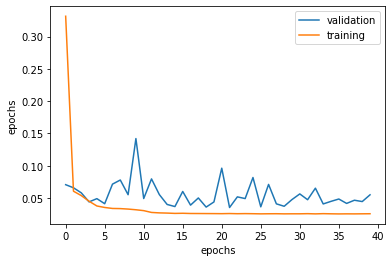

In [8]:
if load_dataset_from_excel:
  [modelo,history] = make_prediction(dataFrame,best_results_of_simulation00[len(best_results_of_simulation01)-1]['parameters'])
else:
  [modelo,history] = make_prediction(dataFrame,best_results_of_simulation00[len(best_results_of_simulation00)-1][1]['parameters'])

plt.plot(history.history['val_mse'], label = "validation")
plt.plot(history.history['mse'], label = "training")
plt.xlabel('epochs')
plt.ylabel('epochs')
plt.legend()
plt.show()

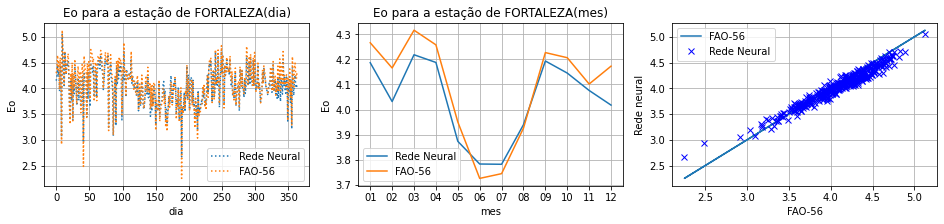

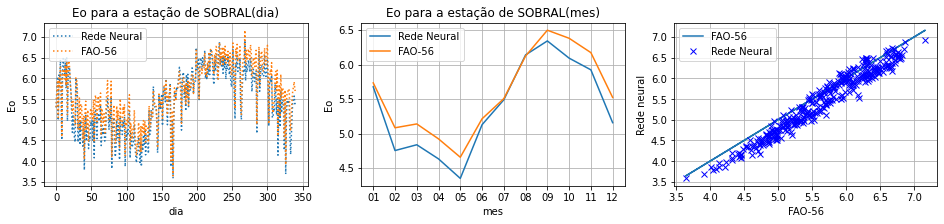

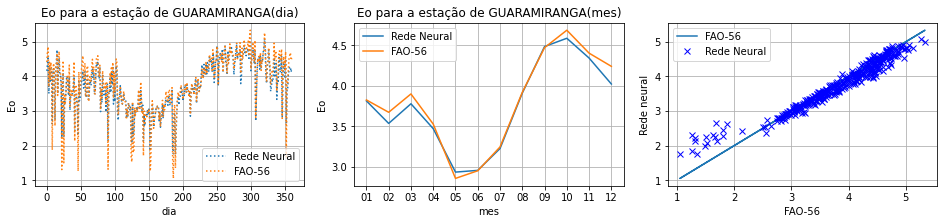

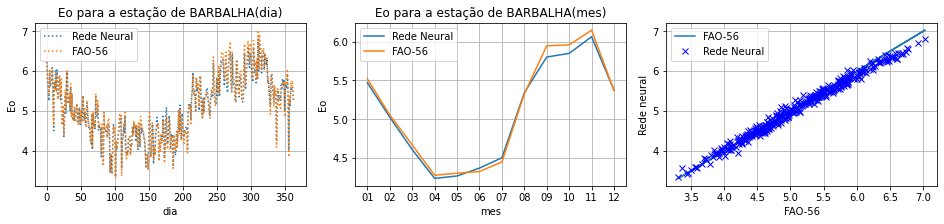

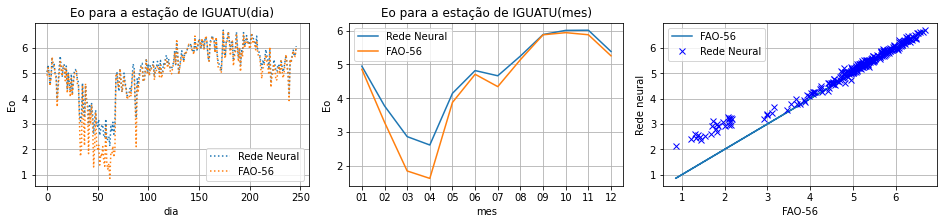

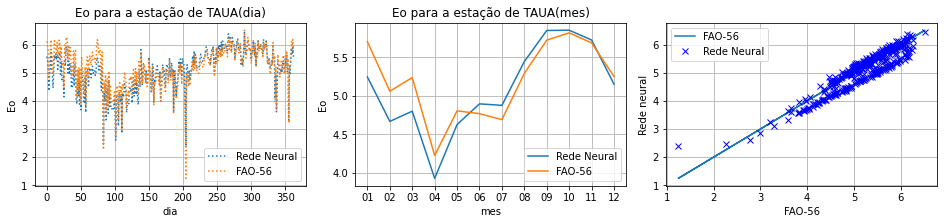

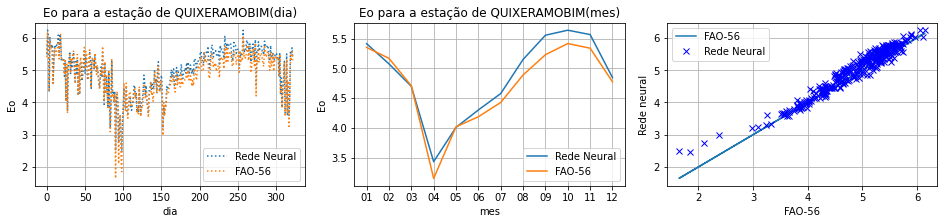

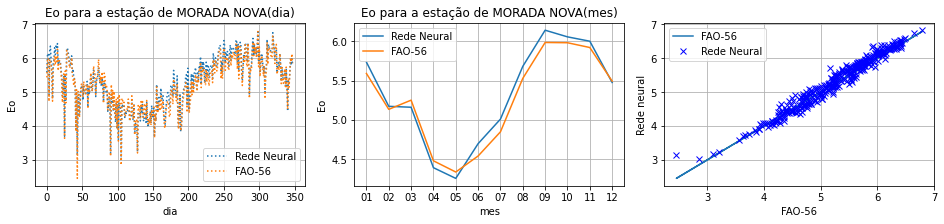

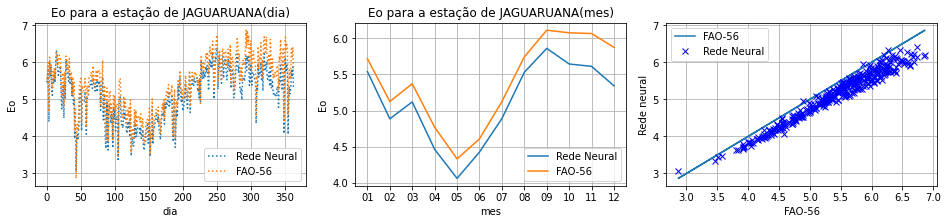

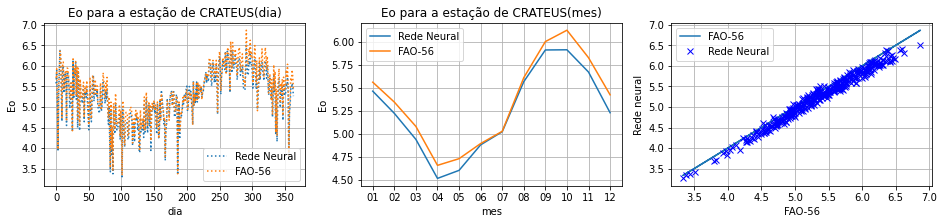

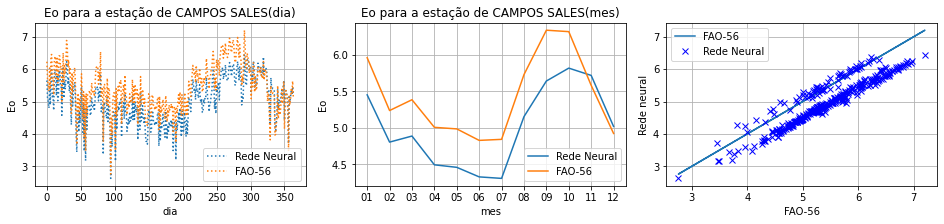

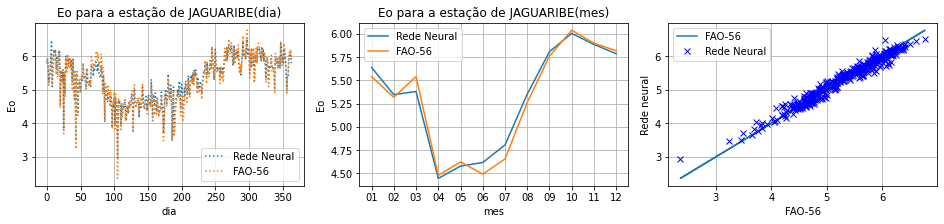

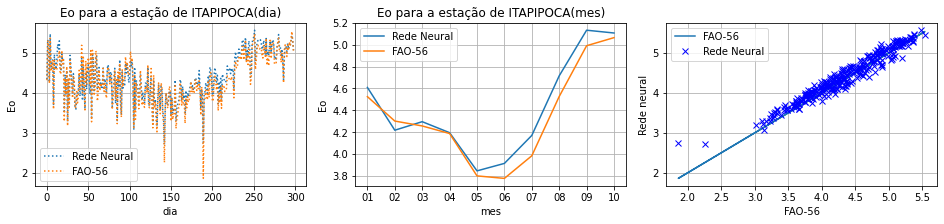

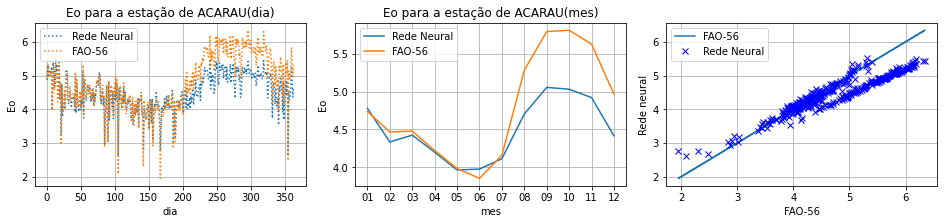

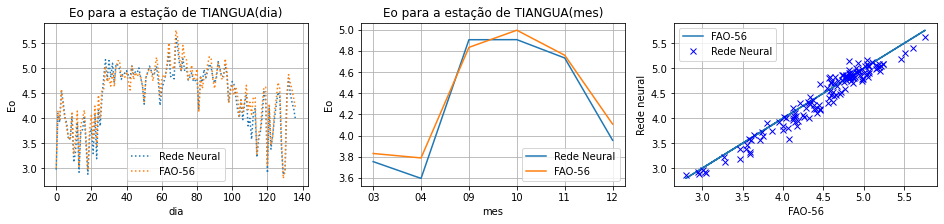

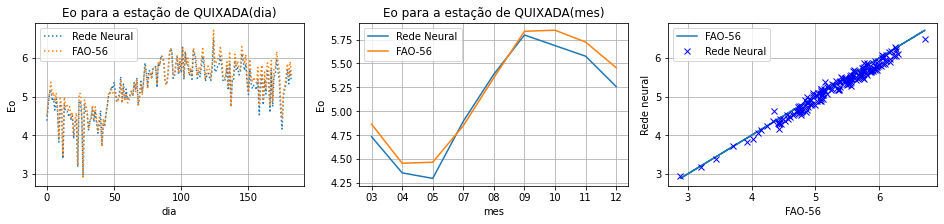

In [118]:
test_labels = pd.DataFrame(modelo.test_labels)
prediction_test = pd.DataFrame(modelo.prediction_test)

test_labels['data'] = modelo.test_labels.index
prediction_test['data'] = modelo.test_labels.index

test_labels['mes'] = [mes for mes in modelo.mes]
prediction_test['mes'] = [mes for mes in modelo.mes]
test_labels['ano'] = [mes for mes in modelo.ano]
prediction_test['ano'] = [mes for mes in modelo.ano]

test_labels_gruopby_data = test_labels.groupby(['data']).mean()
prediction_test_gruopby_data = prediction_test.groupby(['data']).mean()

test_labels_gruopby_month = test_labels.groupby(['mes']).mean()
prediction_test_gruopby_month = prediction_test.groupby(['mes']).mean()

test_labels['estacao_id'] = [id for id in modelo.estacao_id ]
prediction_test['estacao_id'] = [id for id in modelo.estacao_id ]

#display(prediction_test)

results_by_estation = get_graphs_and_metrics_grouped_by_estacao_id(prediction_test,test_labels,'mes','2018',localization,id_2,show_picture = True)

In [10]:
display(results_by_estation.T)

,código da estação,Quantidade de dados,coeficiente de determinação(dia),MSE(dia),coeficiente de determinação(mes),MSE(mes)
FORTALEZA,A305,364,0.837761,0.025577,0.509602,0.017751
SOBRAL,A306,341,0.827078,0.085348,0.816496,0.079295
GUARAMIRANGA,A314,361,0.940691,0.037786,0.940333,0.017745
BARBALHA,A315,364,0.927308,0.04489,0.918236,0.037998
IGUATU,A319,247,0.984916,0.025086,0.993905,0.012016
TAUA,A324,363,0.763346,0.115057,0.736801,0.099317
QUIXERAMOBIM,A325,323,0.857031,0.07029,0.899042,0.052373
MORADA NOVA,A332,348,0.938453,0.032434,0.956374,0.020462
JAGUARUANA,A339,364,0.818306,0.100133,0.708221,0.089247
CRATEUS,A342,364,0.948394,0.020504,0.940162,0.014259


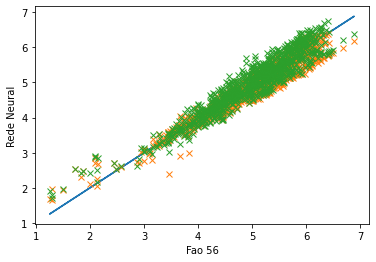

0.9327291963393662


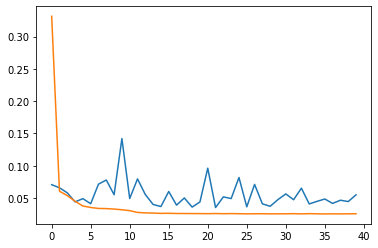

In [11]:
modelo.compare(1000,True)
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.show()

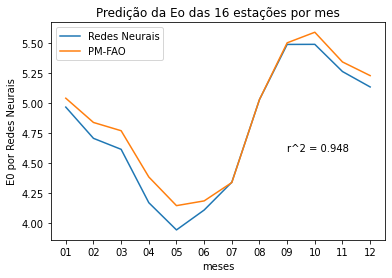

0.9484830159460415

In [12]:
plt.plot(prediction_test_gruopby_month, label = 'Redes Neurais')
plt.plot(test_labels_gruopby_month, label = 'PM-FAO')
plt.legend()
plt.text(8,4.6,'r^2 = '+str(round(r2_score(prediction_test_gruopby_month,test_labels_gruopby_month),3)))
plt.xlabel('meses')
plt.ylabel('E0 por Redes Neurais')
plt.title('Predição da Eo das 16 estações por mes')
plt.show()

display(r2_score(prediction_test_gruopby_month,test_labels_gruopby_month))

## **All results of the simulation 01**

This subsection is included the graphs and metrics such as  $r^2$ and MSE per monthly mean and day. The graphs that present the monthly mean results are related to 2018, the year which contains most data from the test data set.

0.932753874892825


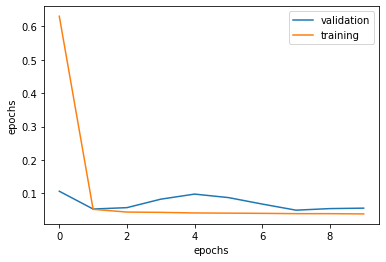

In [31]:
if load_dataset_from_excel:
  [modelo,history] = make_prediction(dataFrame,best_results_of_simulation01[len(best_results_of_simulation01)-1]['parameters'])
else:
  [modelo,history] = make_prediction(dataFrame,best_results_of_simulation01[len(best_results_of_simulation00)-1][1]['parameters'])

plt.plot(history.history['val_mse'], label = "validation")
plt.plot(history.history['mse'], label = "training")
plt.xlabel('epochs')
plt.ylabel('epochs')
plt.legend()
plt.show()

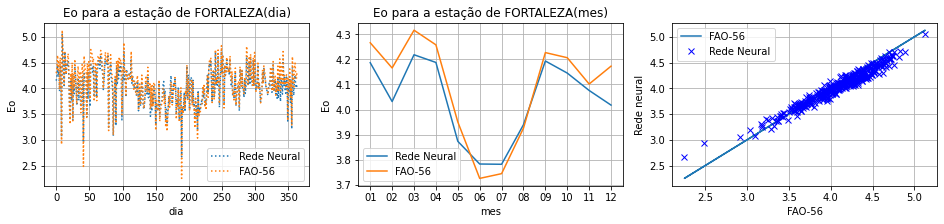

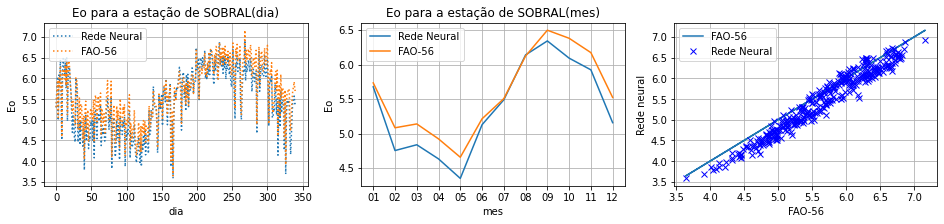

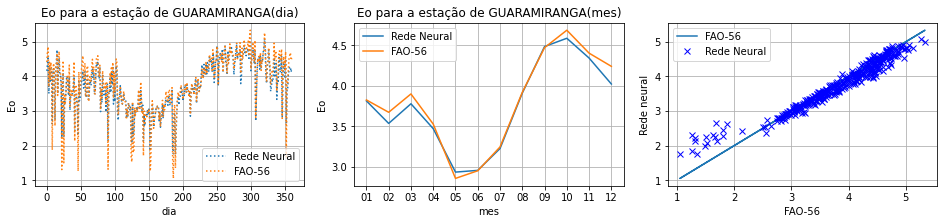

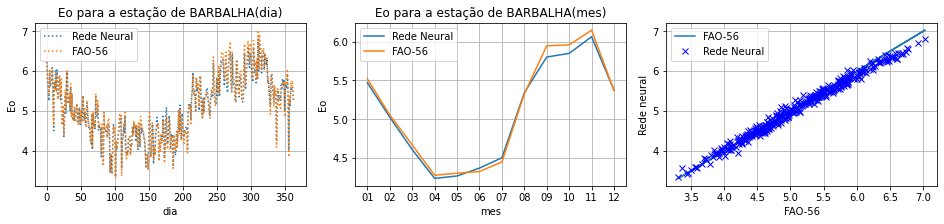

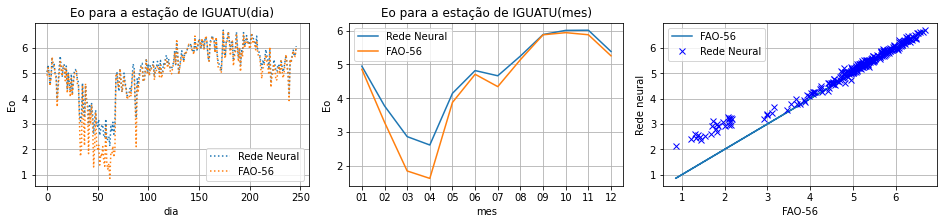

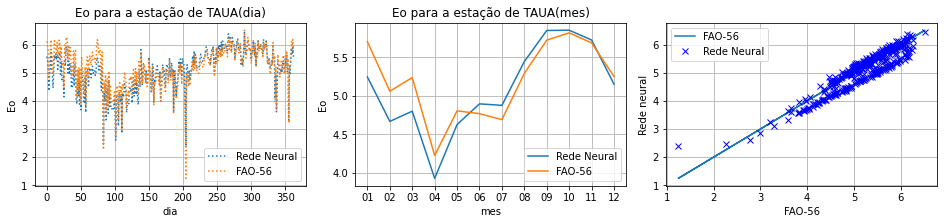

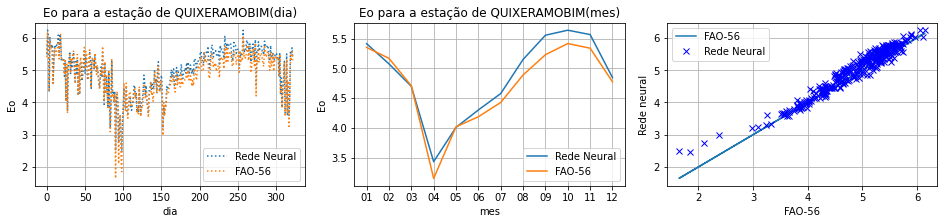

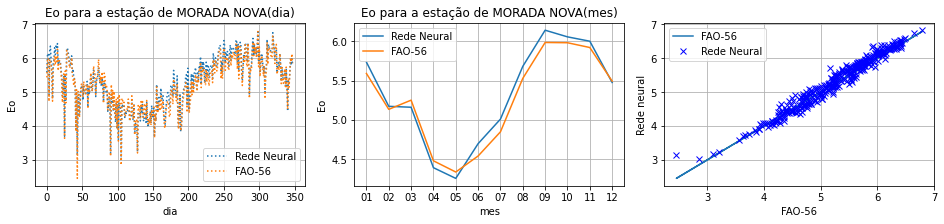

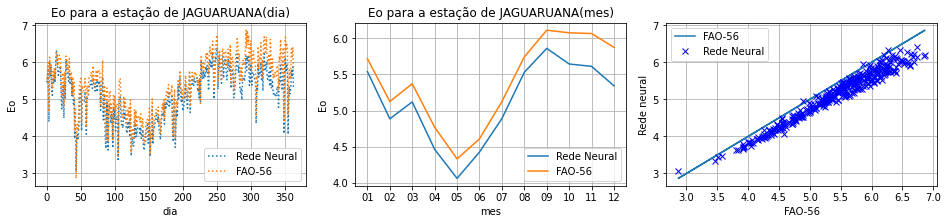

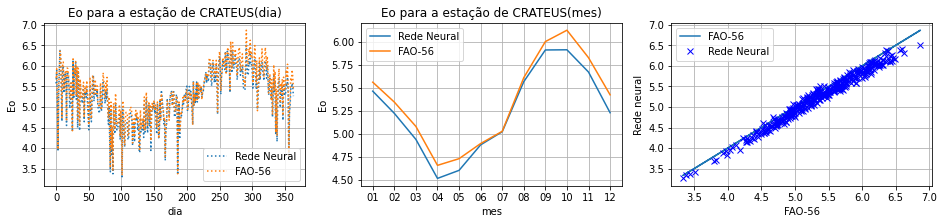

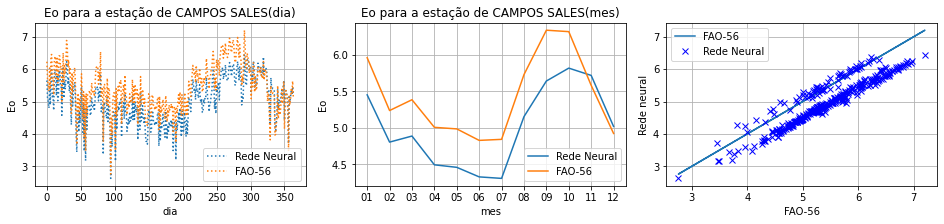

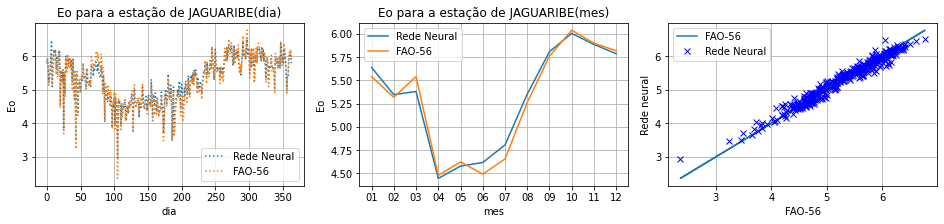

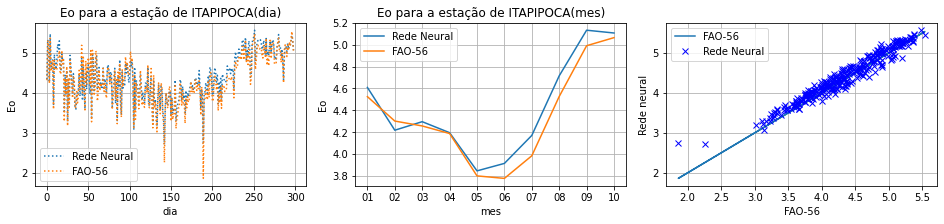

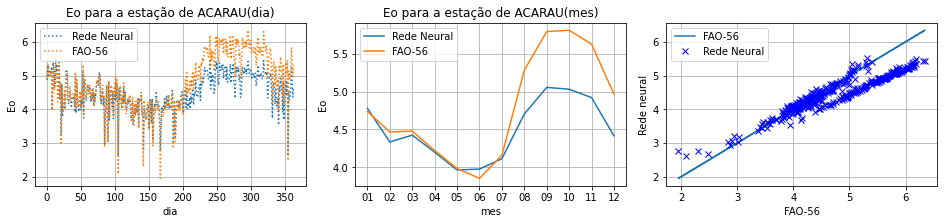

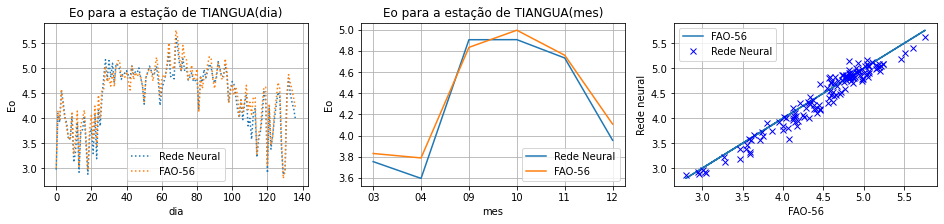

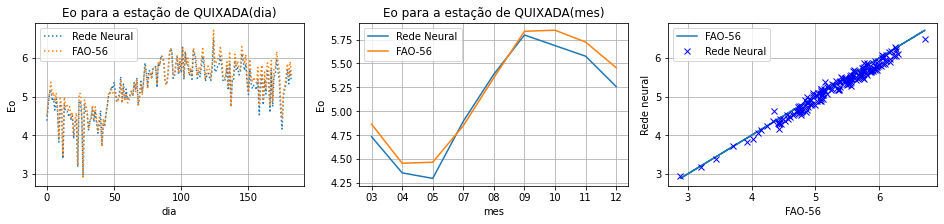

In [119]:
test_labels = pd.DataFrame(modelo.test_labels)
prediction_test = pd.DataFrame(modelo.prediction_test)

test_labels['data'] = modelo.test_labels.index
prediction_test['data'] = modelo.test_labels.index

test_labels['mes'] = [mes for mes in modelo.mes]
prediction_test['mes'] = [mes for mes in modelo.mes]
test_labels['ano'] = [mes for mes in modelo.ano]
prediction_test['ano'] = [mes for mes in modelo.ano]

test_labels_gruopby_data = test_labels.groupby(['data']).mean()
prediction_test_gruopby_data = prediction_test.groupby(['data']).mean()

test_labels_gruopby_month = test_labels.groupby(['mes']).mean()
prediction_test_gruopby_month = prediction_test.groupby(['mes']).mean()

test_labels['estacao_id'] = [id for id in modelo.estacao_id ]
prediction_test['estacao_id'] = [id for id in modelo.estacao_id ]

#display(prediction_test)

results_by_estation = get_graphs_and_metrics_grouped_by_estacao_id(prediction_test,test_labels,'mes','2018',localization,id_2,show_picture = True)

In [120]:
display(results_by_estation.T)

,código da estação,Quantidade de dados,coeficiente de determinação(dia),MSE(dia),coeficiente de determinação(mes),MSE(mes)
FORTALEZA,A305,364,0.918942,0.012779,0.719282,0.006573
SOBRAL,A306,341,0.862727,0.067753,0.856537,0.057718
GUARAMIRANGA,A314,361,0.929998,0.044599,0.969084,0.008787
BARBALHA,A315,364,0.982463,0.01083,0.988614,0.004557
IGUATU,A319,247,0.917337,0.137472,0.829069,0.20872
TAUA,A324,363,0.83746,0.079024,0.785602,0.064892
QUIXERAMOBIM,A325,323,0.907032,0.045708,0.921358,0.034245
MORADA NOVA,A332,348,0.95476,0.023841,0.965667,0.012937
JAGUARUANA,A339,364,0.80106,0.109637,0.669202,0.099547
CRATEUS,A342,364,0.946427,0.021286,0.918832,0.016497


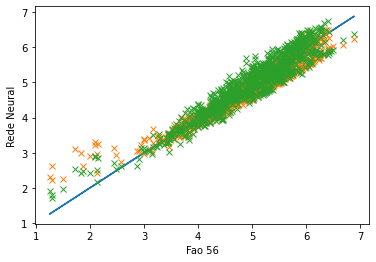

0.932753874892825


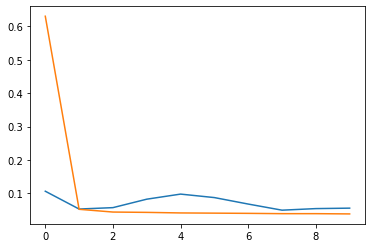

In [121]:
modelo.compare(1000,True)
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.show()

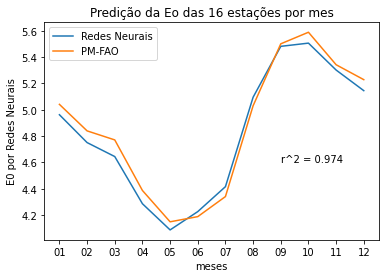

0.9737993576793874

In [122]:
plt.plot(prediction_test_gruopby_month, label = 'Redes Neurais')
plt.plot(test_labels_gruopby_month, label = 'PM-FAO')
plt.legend()
plt.text(8,4.6,'r^2 = '+str(round(r2_score(prediction_test_gruopby_month,test_labels_gruopby_month),3)))
plt.xlabel('meses')
plt.ylabel('E0 por Redes Neurais')
plt.title('Predição da Eo das 16 estações por mes')
plt.show()

display(r2_score(prediction_test_gruopby_month,test_labels_gruopby_month))

## Performing the hypothesis test

Based on the set of the hyperparameters that produced the highest $r^2$ in simulation 1 and simulation 2, 2 same-size data sets are created using them. In order to ensure that one set of the hyperparameters is better than the other one in terms of mean, the hypothesis test is carried out following the below statements.

$h_{0} :$ Both means are statistically similar.

$h_{1} :$ The means of the distributions underlying the samples are unequal

If the p-value is less or equals 0.05, the null hypothesis($h_{0}$) is rejected and the alternative hypothesis($h_{1}$) is accepted. Otherwise, if the p-value is larger than 0.05, the $h_0$ is accepted. In relation to this project, accepting the $h_0$ means that both sets of hyperparameters produce the same results statistically speaking. Thus, it is more advantageous to work with the first one as it uses fewer features.  

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html

In [ ]:
modelo0_sample = [make_prediction(dataFrame,parameter00)[0].compare(100) for x in range(50)]
modelo1_sample = [make_prediction(dataFrame,parameter01)[0].compare(100) for x in range(50)]

In [123]:
ttest_ind(modelo1_sample,modelo0_sample,alternative='two-sided',equal_var=False)

Ttest_indResult(statistic=-0.9892896840101363, pvalue=0.32499800251563415)